## Setup for google colaboratory users
- If you use google colaboratory for your programming environment, please run the below. 
- You have to give a permission to refer the data in your google drive to import real data you have.

In [ ]:
# Mount Google Drive to read files in Colab
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

- Change "TS" to your own folder name. (the folder where you save the data)

In [ ]:
%cd "/content/drive/MyDrive/TS"

In [ ]:
ls

First, import the libraries.

In [1]:
# Install the necessary libraries
!pip install -U statsmodels
#The code below is for displaying Japanese, install if you need.
#!pip install japanize_matplotlib

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.2/9.2 MB 5.7 MB/s eta 0:00:0000:0100:01
  Attempting uninstall: statsmodels
    Found existing installation: statsmodels 0.13.2
    Uninstalling statsmodels-0.13.2:
      Successfully uninstalled statsmodels-0.13.2

[notice] A new release of pip available: 22.3 -> 22.3.1
[notice] To update, run: pip install --upgrade pip


In [2]:
# Code 4.1
import math

import numpy as np
import pandas as pd
import scipy as sp
import statsmodels.api as sm
from sklearn.decomposition import PCA
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler

In [3]:
#####
from matplotlib import pyplot as plt
from matplotlib.pylab import rcParams
rcParams["figure.figsize"] = 15, 6
#import japanize_matplotlib

Then, load the data. Figure 4.1 can be created by extracting common factors of GDP of Japan from GDP with expenditure approach and GDP with distribution approach using the maximum likelihood Dynamic Factor Model.

In [4]:
# Code 4.2
# Load the data
gdp = pd.read_excel("data_4_eng.xlsx", sheet_name="GDP (cabinet)", header=[0])
gdpe, gdpi = gdp.iloc[:, 1], gdp.iloc[:, 2]
dti = pd.date_range("1994-03-31", periods=len(gdp), freq="Q")
gdpei = pd.concat([gdpe, gdpi], axis=1)
gdpei["dln_expenditure"] = (np.log(gdpei.expenditure)).diff(4) * 100
gdpei["dln_distribution"] = (np.log(gdpei.distribution)).diff(4) * 100
data_gdp = pd.DataFrame(gdpei.loc[4:, :][["dln_expenditure", "dln_distribution"]].to_numpy())

# Define the Dynamic Factor Model
class DFModel(sm.tsa.statespace.MLEModel):
    # Set a Dynamic Factor Model with 1 common factor
    def __init__(self, data_gdp):
        super(DFModel, self).__init__(
            data_gdp,
            k_states=1,
            k_posdef=1,
            initialization="approximate_diffuse",
            loglikelihood_burn=1,
        )
        self.ssm["design"] = [[1], [1]]
        self.ssm["state_intercept"] = [1]
        self.ssm["transition"] = [1]
        self.ssm["selection"] = [1]

    @property
    # Set the initial value of the parameter to be estimated
    def start_params(self):
        return [1, 1, 1, 1, 1, 1, 1]

    def transform_params(self, unconstrained):
        return unconstrained**2

    def untransform_params(self, constrained):
        return constrained**0.5

    # Update the Kalman filter
    def update(self, params, *args, **kwargs):
        params = super(DFModel, self).update(params, *args, **kwargs)
        self.ssm["obs_cov", 0, 0] = params[0]
        self.ssm["obs_cov", 1, 0] = params[1]
        self.ssm["state_cov", 0, 0] = params[2]
        self.ssm["state_intercept", 0, 0] = params[3]
        self.ssm["transition", 0, 0] = params[4]
        self.ssm["design", 0, 0] = params[5]
        self.ssm["design", 1, 0] = params[6]


# Estimation of the Dynamic Factor Model
model_dfm = DFModel(data_gdp.to_numpy())
result_dfm = model_dfm.fit()

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  4.87433D+00    |proj g|=  8.40384D+00

At iterate    5    f=  3.42011D+00    |proj g|=  2.83703D-01

At iterate   10    f=  3.38302D+00    |proj g|=  8.47952D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     14     18      1     0     0   1.175D-04   3.383D+00
  F =   3.3829693816330915     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             


 This problem is unconstrained.


Text(0, 0.5, '%')

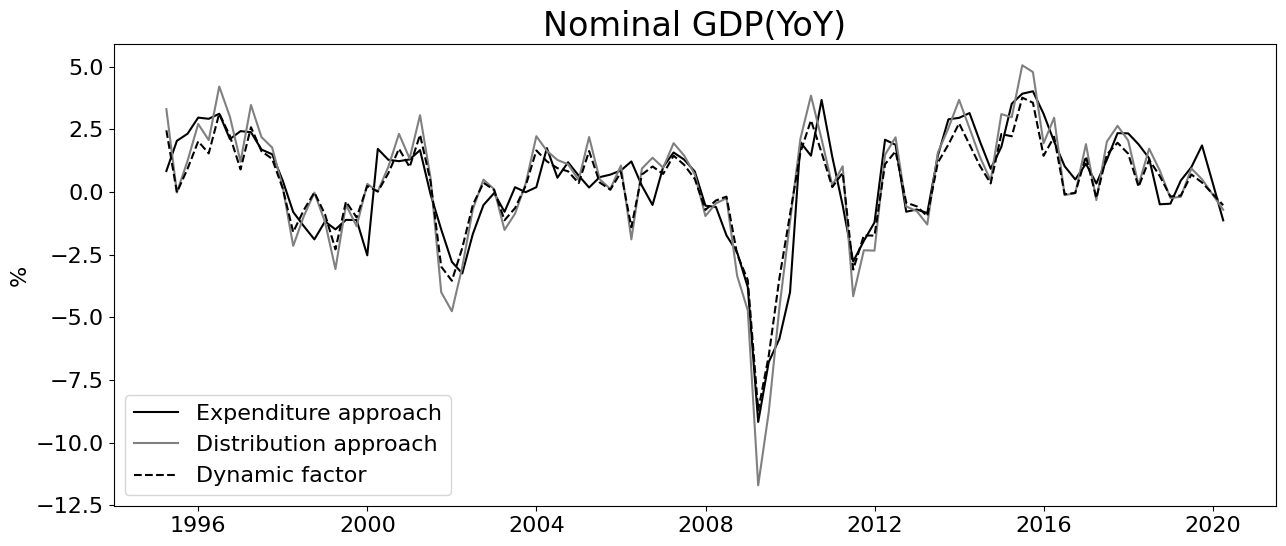

In [5]:
#####
# Draw the graph
plt.title("Nominal GDP(YoY)", fontsize=24)
plt.plot(dti[4:], data_gdp.iloc[:, 0], label="Expenditure approach", color="black")
plt.plot(dti[4:], data_gdp.iloc[:, 1], label="Distribution approach", color="grey")
plt.plot(dti[4:], result_dfm.states.smoothed, label="Dynamic factor", color="black", linestyle="dashed")
plt.legend(loc="lower left", fontsize=16)
plt.tick_params(labelsize=16)
plt.ylabel("%", fontsize=16)

Using a data set contains 219 monthly macroeconomic variables for Japan, we can create Figure 4.2 by estimating common factors (Set the number of common factors to be 5 by let "n_components=5") with principal component analysis. 

In [6]:
# Code 4.3
# Load the data
rawdata = pd.read_excel("data_4_eng.xlsx", sheet_name="MS(JJIE2020)", header=[0])
msdata = rawdata.iloc[:, 1:]
dti = pd.date_range("1974-01-01", periods=len(msdata), freq="M")

# Estimation of common factors (set the number of factors to be 5) by principal component analysis.
scaler = StandardScaler()
scaler.fit(msdata)
msdata_std = scaler.transform(msdata)
pca = PCA(n_components=5)
pca.fit(msdata_std)
pca_factor = pca.transform(msdata_std)

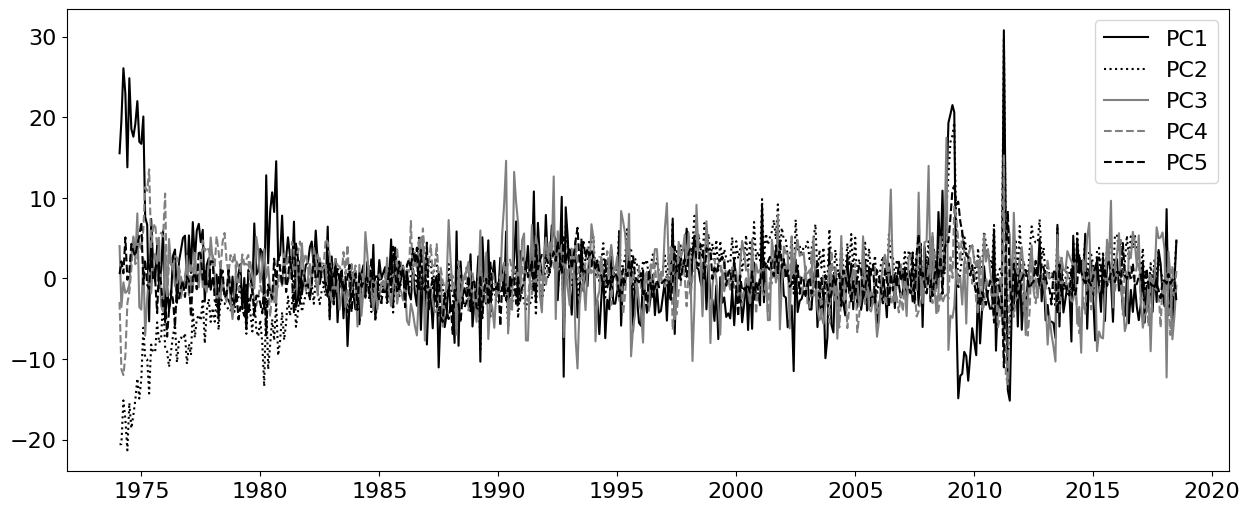

In [7]:
#####
# Draw the graph
# "PC1/2..."" means "first/second/... principal component"
plt.plot(dti, pca_factor[:, 0], label="PC1", color="black")
plt.plot(dti, pca_factor[:, 1], label="PC2", color="black", linestyle="dotted")
plt.plot(dti, pca_factor[:, 2], label="PC3", color="grey")
plt.plot(dti, pca_factor[:, 3], label="PC4", color="grey", linestyle="dashed")
plt.plot(dti, pca_factor[:, 4], label="PC5", color="black", linestyle="dashed")
plt.legend(loc="upper right", fontsize=16)
plt.tick_params(labelsize=16)

The selection of the number of common factors by the Information Criterion of Bai and Ng (2002) can be computed with the following code. And, since there are 6 differenct equations (Equation (4.13)~(4.18) in Chapter 4.3) about the Information Criterion of Bai and Ng (2002), the code is designed to select one of them. 

In [8]:
# Code 4.4
MAX_K = 20  # Maximum factor number（20 series）

#Selection of the number of common factors by the Information Criterion of Bai and Ng (2002)
bn_result = np.zeros(MAX_K)
# Select one from the 6 Information Criterions (1~6)
equation = str(input("Select one from the 6 Information Criterions (1~6): "))
for npc in range(1, MAX_K + 1):
    scaler = StandardScaler()
    scaler.fit(msdata)
    msdata_std = scaler.transform(msdata)
    pca = PCA(n_components=npc)
    pca.fit(msdata_std)
    pca_factor = pca.transform(msdata_std)
    df_pca_factor = pd.DataFrame(pca_factor)
    bnols = LinearRegression()
    bnols.fit(df_pca_factor, msdata_std)
    fitted = bnols.predict(df_pca_factor)
    sigmahat = ((((msdata_std - fitted) ** 2).sum(axis=0)).sum(axis=0)) / (
        len(msdata) * len(msdata.T)
    )
    pca_factor_MAX_K = pca.transform(msdata_std)
    df_pca_factor_MAX_K = pd.DataFrame(pca_factor_MAX_K)
    bnols_MAX_K = LinearRegression()
    bnols_MAX_K.fit(df_pca_factor_MAX_K, msdata_std)
    fitted_MAX_K = bnols_MAX_K.predict(df_pca_factor_MAX_K)
    sigmahat_MAX_K = ((((msdata_std - fitted_MAX_K) ** 2).sum(axis=0)).sum(axis=0)) / (
        len(msdata) * len(msdata.T)
    )
    if equation == "1":
        bn_result[npc - 1] = math.log(sigmahat) + npc * (
            (len(msdata.T) + len(msdata)) / (len(msdata.T) * len(msdata))
        ) * math.log((len(msdata.T) * len(msdata)) / (len(msdata.T) + len(msdata)))
    elif equation == "2":
        bn_result[npc - 1] = math.log(sigmahat) + npc * (
            (len(msdata.T) + len(msdata)) / (len(msdata.T) * len(msdata))
        ) * math.log(min(len(msdata.T), len(msdata)))
    elif equation == "3":
        bn_result[npc - 1] = math.log(sigmahat) + npc * (
            math.log(min(len(msdata.T), len(msdata))) / min(len(msdata.T), len(msdata))
        )
    elif equation == "4":
        bn_result[npc - 1] = sigmahat + npc * sigmahat_MAX_K * (
            (len(msdata.T) + len(msdata)) / (len(msdata.T) * len(msdata))
        ) * math.log((len(msdata.T) * len(msdata)) / (len(msdata.T) + len(msdata)))
    elif equation == "5":
        bn_result[npc - 1] = sigmahat + npc * sigmahat_MAX_K * (
            (len(msdata.T) + len(msdata)) / (len(msdata.T) * len(msdata))
        ) * math.log(min(len(msdata.T), len(msdata)))
    elif equation == "6":
        bn_result[npc - 1] = sigmahat + npc * sigmahat_MAX_K * (
            math.log(min(len(msdata.T), len(msdata))) / min(len(msdata.T), len(msdata))
        )
best_npc = pd.DataFrame(bn_result).idxmin() + 1

# Output the result table
df_table = pd.DataFrame([bn_result])
df_table.columns = [f"Number of principal components={i+1}" for i in range(MAX_K)]
df_table.index = ["Information Criterion of Bai and Ng"]
print(df_table)
print(f"Best number of principal components={best_npc.to_numpy()}")

Select one from the 6 Information Criterions (1~6): 1
                                     Number of principal components=1  \
Information Criterion of Bai and Ng                         -0.129169   

                                     Number of principal components=2  \
Information Criterion of Bai and Ng                         -0.246363   

                                     Number of principal components=3  \
Information Criterion of Bai and Ng                         -0.323885   

                                     Number of principal components=4  \
Information Criterion of Bai and Ng                         -0.357859   

                                     Number of principal components=5  \
Information Criterion of Bai and Ng                         -0.375523   

                                     Number of principal components=6  \
Information Criterion of Bai and Ng                         -0.390271   

                                     Number of principal compone

The selection of the number of common factors by the Information Criterion of Onatski(2010) can be computed with the following code.

In [9]:
# Code 4.5
# Selecting the number of common factors with the Information Criterion of Onatski(2010)
scaler = StandardScaler()
scaler.fit(msdata)
msdata_std = scaler.transform(msdata)
lambda_eig = pd.DataFrame(
    np.linalg.eig(np.dot(msdata_std.T, msdata_std) / len(msdata_std))
)
j = MAX_K + 1
best_npc = MAX_K
diff_lambda_eig = (
    np.ravel(lambda_eig.iloc[0, :-1]) - np.ravel(lambda_eig.iloc[0, 1:])
)[0:j]
while best_npc != j:
    y = [
        lambda_eig.iloc[0, j + 1],
        lambda_eig.iloc[0, j + 2],
        lambda_eig.iloc[0, j + 3],
        lambda_eig.iloc[0, j + 4],
        lambda_eig.iloc[0, j + 5],
    ]
    x = [
        (j - 1) ** (2 / 3),
        (j) ** (2 / 3),
        (j + 1) ** (2 / 3),
        (j + 2) ** (2 / 3),
        (j + 3) ** (2 / 3),
    ]
    ools = LinearRegression()
    ools.fit(pd.DataFrame(x), pd.DataFrame(y))
    delta = 2 * np.abs(ools.coef_)
    check = diff_lambda_eig >= delta
    if not check.any() == True:
        best_npc = 0
    else:
        best_npc = np.max(np.where(check==True)[1]) + 1
    if j == best_npc:
        break
    else:
        j = best_npc + 1

# Output the result table
print(f"Best number of principal components={best_npc}")

Best number of principal components=4


The selection of the number of common factors by the Information Criterion of Ahn and Horenstein (2013) can be computed with the following code.

In [10]:
# Code 4.6
# Selecting the number of common factors with the Information Criterion of  Ahn and Horenstein (2013) 
ah_result = np.zeros(MAX_K + 1)
for npc in range(1, MAX_K + 2):
    scaler = StandardScaler()
    scaler.fit(msdata)
    msdata_std = scaler.transform(msdata)
    pca = PCA(n_components=npc)
    pca.fit(msdata_std)
    pca_factor = pca.transform(msdata_std)
    df_pca_factor = pd.DataFrame(pca_factor)
    ahols = LinearRegression()
    ahols.fit(df_pca_factor, msdata_std)
    fitted = ahols.predict(df_pca_factor)
    ah_ssr = (((msdata_std - fitted) ** 2).sum(axis=0)).sum(axis=0)
    ah_tss = ((msdata_std**2).sum(axis=0)).sum(axis=0)
    trace = 1 - ah_ssr / ah_tss
    ah_result[npc - 1] = trace
marg_1 = pd.DataFrame(ah_result)
marg_2 = pd.concat(
    [pd.DataFrame(np.zeros(len(marg_1.T))), marg_1.iloc[0 : marg_1.shape[0] - 1].T],
    axis=1,
)
marg = pd.DataFrame(marg_1.T.to_numpy() - marg_2.to_numpy())
marg_trans = marg.T
aher_num = marg_trans[0 : marg.shape[1] - 1].T
aher_den = marg_trans[1 : marg.shape[1]].T
aher = pd.DataFrame(aher_num.to_numpy() / aher_den.to_numpy())
best_npc = pd.DataFrame(aher.T).idxmax() + 1

# Output the result table
df_table = pd.DataFrame(aher.to_numpy())
df_table.columns = [f"Number of principal components={i+1}" for i in range(MAX_K)]
df_table.index = ["Information Criterion of Ahn and Horenstein"]
print(df_table)
print(f"Best number of principal components={best_npc.to_numpy()}")

                                             Number of principal components=1  \
Information Criterion of Ahn and Horenstein                          1.262112   

                                             Number of principal components=2  \
Information Criterion of Ahn and Horenstein                          1.549946   

                                             Number of principal components=3  \
Information Criterion of Ahn and Horenstein                          1.808501   

                                             Number of principal components=4  \
Information Criterion of Ahn and Horenstein                          1.404891   

                                             Number of principal components=5  \
Information Criterion of Ahn and Horenstein                          1.114752   

                                             Number of principal components=6  \
Information Criterion of Ahn and Horenstein                          1.116186   

                      

Using the common factors extracted by principal component analysis to predict the Dynamic Factor Model, Figure 4.3 can be produced.

In [11]:
# Code 4.7
# Prediction of Dynamic Factor Model by principal component analysis
predict_result_list, sqe_result_list, ah_result_list = [], [], []
PERIOD = 120  # Sample size of training data（120 months）
H = 12  # Forecast horizon（12 months）
MAX_K = 20  # Maximum number of factors（20 series）
data_y = pd.DataFrame(msdata.x126)
data_x = pd.DataFrame(msdata)

vsample, hsample = len(data_x), len(data_x.columns)
for i in range((vsample - H) - PERIOD):
    predict_result, sqe_result, ah_result = (
        np.zeros(MAX_K + 1),
        np.zeros(MAX_K + 1),
        np.zeros(MAX_K + 1),
    )
    for npc in range(1, MAX_K + 1 + 1):
        train_x = data_x[i : i + PERIOD]
        test_x = data_x[i : i + PERIOD + 1]
        scaler = StandardScaler()
        scaler.fit(train_x)
        train_x_std = scaler.transform(train_x)
        scaler.fit(test_x)
        test_x_std = scaler.transform(test_x)
        # Principal component analysis
        pca = PCA(n_components=npc)
        pca.fit(train_x_std)
        pca_train = pca.transform(train_x_std)
        pca.fit(test_x_std)
        pca_test = pca.transform(test_x_std)[PERIOD : PERIOD + 1]
        
        df_pca_train = pd.DataFrame(pca_train)
        df_pca_test = pd.DataFrame(pca_test)
        train_x = pd.concat(
            [pd.DataFrame(df_pca_train.to_numpy()), 
             pd.DataFrame(data_y[i : i + PERIOD].to_numpy())], 
            axis=1,
        )
        train_y = data_y[H + i : H + i + PERIOD]
        test_x = pd.concat(
            [pd.DataFrame(df_pca_test.to_numpy()), 
             pd.DataFrame(data_y[i + PERIOD : i + PERIOD + 1].to_numpy())], 
            axis=1,
        )
        test_y = data_y[H + i + PERIOD : H + i + PERIOD + 1]
        # Estimation of model
        model = LinearRegression()
        model.fit(train_x, train_y)
        forecast = model.predict(test_x)
        sqe = (test_y - forecast) ** 2
        ahols = LinearRegression()
        ahols.fit(train_x, train_y)
        fitted = ahols.predict(train_x)
        ah_ssr = (((train_x - fitted) ** 2).sum(axis=0)).sum(axis=0)
        ah_tss = ((train_x**2).sum(axis=0)).sum(axis=0)
        trace = 1 - ah_ssr / ah_tss
        predict_result[npc - 1] = forecast
        sqe_result[npc - 1] = sqe.sum(axis=0)
        ah_result[npc - 1] = trace
    marg_1 = pd.DataFrame(ah_result)
    marg_2 = pd.concat(
        [pd.DataFrame(np.zeros(len(marg_1.T))), marg_1.iloc[0 : marg_1.shape[0] - 1].T],
        axis=1,
    )
    marg = pd.DataFrame(marg_1.T.to_numpy() - marg_2.to_numpy())
    marg_trans = marg.T
    aher_num = marg_trans[0 : marg.shape[1] - 1].T
    aher_den = marg_trans[1 : marg.shape[1]].T
    aher = pd.DataFrame(aher_num.to_numpy() / aher_den.to_numpy())
    best_npc = pd.DataFrame(aher.T).idxmax() + 1
    predict_result_list.append(predict_result[best_npc - 1])
    sqe_result_list.append(sqe_result[best_npc - 1])
    ah_result_list.append(best_npc)

In [12]:
#####
# AR forecasting
predict_resultAR_list, sqe_resultAR_list = [], []
PERIOD = 120  # Sample size of training data（120 months）
H = 12  # Forecast horizon（12 months）

predict_resultAR = np.zeros((vsample - H) - PERIOD)
sqe_resultAR = np.zeros((vsample - H) - PERIOD)
for i in range((vsample - H) - PERIOD):
    # Deciding training data
    train_x = data_y[i : i + PERIOD]
    train_y = data_y[H + i : H + i + PERIOD]
    # Deciding test data
    test_x = data_y[i + PERIOD : i + PERIOD + 1]
    test_y = data_y[H + i + PERIOD : H + i + PERIOD + 1]
    # AR model
    model = LinearRegression()
    model.fit(train_x, train_y)
    forecast = model.predict(test_x)
    predict_resultAR[i] = forecast
    sqe = ((test_y - forecast) ** 2).sum(axis=0)
    sqe_resultAR[i] = sqe

predict_resultAR_list.append(predict_resultAR)
sqe_resultAR_list.append(sqe_resultAR)

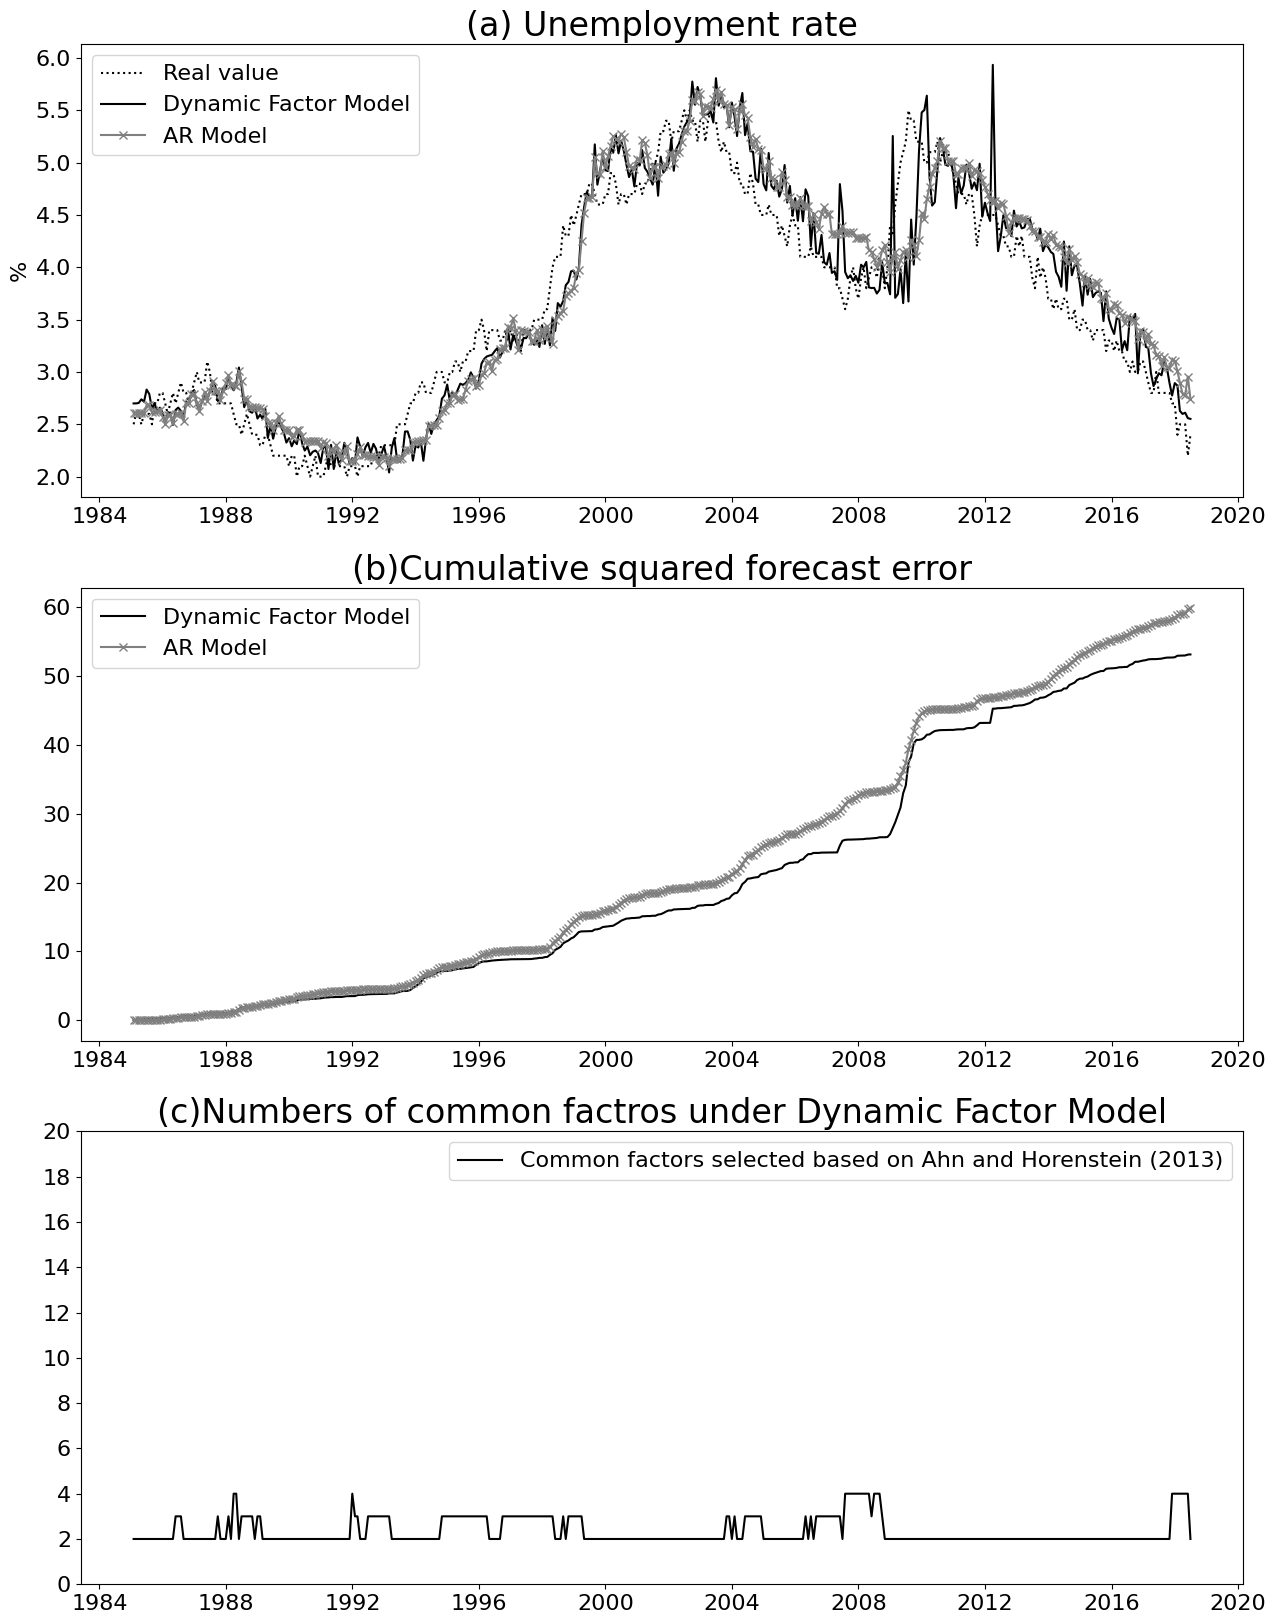

In [13]:
#####
# Draw the graph
fig = plt.figure(figsize=(15, 20))
ax1 = fig.add_subplot(3, 1, 1)
ax2 = fig.add_subplot(3, 1, 2)
ax3 = fig.add_subplot(3, 1, 3)
ax1.set_title("(a) Unemployment rate", fontsize=24)
ax1.plot(dti[H + PERIOD :], msdata.x126[H + PERIOD :], label="Real value", color="black", linestyle="dotted")
ax1.plot(dti[H + PERIOD :], np.ravel(predict_result_list), label="Dynamic Factor Model", color="black")
ax1.plot(dti[H + PERIOD :], np.ravel(predict_resultAR_list), label="AR Model", color="grey", marker="x")
ax1.legend(loc="upper left", fontsize=16)
ax1.set_ylabel("%", fontsize=16)
ax1.tick_params(labelsize=16)
ax2.set_title("(b)Cumulative squared forecast error", fontsize=24)
ax2.plot(dti[H + PERIOD :], np.ravel(sqe_result_list).cumsum(), label="Dynamic Factor Model", color="black")
ax2.plot(dti[H + PERIOD :], np.ravel(sqe_resultAR_list).cumsum(), label="AR Model", color="grey", marker="x")
ax2.legend(loc="upper left", fontsize=16)
ax2.tick_params(labelsize=16)
ax3.set_title("(c)Numbers of common factros under Dynamic Factor Model", fontsize=24)
ax3.plot(dti[H + PERIOD :], ah_result_list, label="Common factors selected based on Ahn and Horenstein (2013)", color="black")
ax3.legend(loc="upper right", fontsize=16)
ax3.tick_params(labelsize=16)
ax3.set_yticks(np.arange(0, MAX_K + 1, step=2))

Forecast with Dynamic Factor Model using mixed-frequency data. First, load the data.

In [14]:
# Code 4.8
# Forecast with Dynamic Factor Model using mixed-frequency data
# Load the data
data = pd.read_excel("data_4_eng.xlsx", sheet_name="Mixed-frequency", header=[0])
data_m = data.iloc[:, 3:]
data_q = data.iloc[:, 1 : 1 + 1]
data_q = data_q.dropna()
mdlen, qdlen = len(data_m), len(data_q)
mdti = pd.date_range("1994-01-01", periods=mdlen, freq="MS")
qdti = pd.date_range("1994-01-01", periods=qdlen, freq="QS")

Factor Bridge model can be computed by the following code. 

In [15]:
# Code 4.9
PERIOD = 60  # Sample size of training data（60 quarters = 180 months）

# Bridge Model
NPC_BRIDGE = 3  # Number of factors（3 series）
predict_result1_list, predict_result2_list, predict_result3_list = [], [], []
predict_result = np.zeros(((qdlen - 1) - PERIOD) * 3)
for k in range(1, qdlen - PERIOD):

    # Create M3 type bridge model
    df_hatdata3 = data_m.iloc[3 * k : 3 * (k + PERIOD + 1), :]
    scaler = StandardScaler()
    scaler.fit(df_hatdata3)
    df_hatdata3_std = scaler.transform(df_hatdata3)
    pca = PCA(n_components=NPC_BRIDGE)
    pca.fit(df_hatdata3_std)
    pca_df_hatdata3 = pca.transform(df_hatdata3_std)
    mqdata_bbefore3 = pd.concat(
        [
            pd.DataFrame(pca_df_hatdata3),
            pd.DataFrame(df_hatdata3.iloc[:, 0].to_numpy()),
            pd.DataFrame(df_hatdata3.iloc[:, 40].to_numpy()),
        ],
        axis=1,
    )
    mqdata_before3 = mqdata_bbefore3.rolling(window=3, center=False).sum() / 3
    mqdata3 = np.zeros([PERIOD + 1, NPC_BRIDGE + 2])
    for i in range(PERIOD + 1):
        mqdata3[i, :] = mqdata_before3.iloc[3 * (i + 1) - 1, :]
    x3 = mqdata3[0:PERIOD, :]
    y = data_q.iloc[k : k + PERIOD]

    model = LinearRegression()
    model.fit(x3, y)
    predict_result[3 * (k - 1) + 2] = model.predict(mqdata3[PERIOD : PERIOD + 1, :])
    predict_result3_list.append(predict_result[(k - 1) * 3 + 2])

    # Create M2 type bridge model
    df_hatdata2 = data_m.iloc[3 * k - 1 : 3 * (k + PERIOD + 1) - 1, :]
    scaler = StandardScaler()
    scaler.fit(df_hatdata2)
    df_hatdata2_std = scaler.transform(df_hatdata2)
    pca = PCA(n_components=NPC_BRIDGE)
    pca.fit(df_hatdata2_std)
    pca_df_hatdata2 = pca.transform(df_hatdata2_std)
    mqdata_bbefore2 = pd.concat(
        [
            pd.DataFrame(pca_df_hatdata2),
            pd.DataFrame(df_hatdata2.iloc[:, 0].to_numpy()),
            pd.DataFrame(df_hatdata2.iloc[:, 40].to_numpy()),
        ],
        axis=1,
    )
    fitted21 = pd.DataFrame(np.zeros([1, NPC_BRIDGE + 2]))
    for j in range(NPC_BRIDGE + 2):
        tempx21 = pd.DataFrame(mqdata_bbefore2.iloc[:-1, j].to_numpy())
        tempy21 = pd.DataFrame(mqdata_bbefore2.iloc[1:, j].to_numpy())
        model = LinearRegression()
        model.fit(tempx21, tempy21)
        fitted21.iloc[0, j] = (
            model.intercept_ + model.coef_ * mqdata_bbefore2.iloc[-2, j]
        )
    hatdata2 = pd.concat(
        [pd.DataFrame(mqdata_bbefore2.iloc[1:, :].to_numpy()), fitted21], axis=0
    )
    mqdata_before2 = hatdata2.rolling(window=3, center=False).sum() / 3
    mqdata2 = np.zeros([PERIOD + 1, NPC_BRIDGE + 2])
    for i in range(0, PERIOD + 1):
        mqdata2[i, :] = mqdata_before2.iloc[3 * (i + 1) - 1, :]
    x2 = mqdata2[0:PERIOD, :]
    y = data_q.iloc[k : k + PERIOD]
    model = LinearRegression()
    model.fit(x2, y)
    predict_result[3 * (k - 1) + 1] = model.predict(mqdata2[PERIOD : PERIOD + 1, :])
    predict_result2_list.append(predict_result[(k - 1) * 3 + 1])

    # Create M1 type bridge model
    df_hatdata1 = data_m.iloc[3 * k - 2 : 3 * (k + PERIOD + 1) - 2, :]
    scaler = StandardScaler()
    scaler.fit(df_hatdata1)
    df_hatdata1_std = scaler.transform(df_hatdata1)
    pca = PCA(n_components=NPC_BRIDGE)
    pca.fit(df_hatdata1_std)
    pca_df_hatdata1 = pca.transform(df_hatdata1_std)
    mqdata_bbefore1 = pd.concat(
        [
            pd.DataFrame(pca_df_hatdata1),
            pd.DataFrame(df_hatdata1.iloc[:, 0].to_numpy()),
            pd.DataFrame(df_hatdata1.iloc[:, 40].to_numpy()),
        ],
        axis=1,
    )
    fitted11, fitted12 = pd.DataFrame(np.zeros([1, NPC_BRIDGE + 2])), pd.DataFrame(
        np.zeros([1, NPC_BRIDGE + 2])
    )
    for j in range(NPC_BRIDGE + 2):
        tempx11 = pd.DataFrame(mqdata_bbefore1.iloc[:-1, j].to_numpy())
        tempy11 = pd.DataFrame(mqdata_bbefore1.iloc[1:, j].to_numpy())
        model = LinearRegression()
        model.fit(tempx11, tempy11)
        fitted11.iloc[0, j] = (
            model.intercept_ + model.coef_ * mqdata_bbefore1.iloc[-1, j]
        )
        tempx12 = pd.DataFrame(mqdata_bbefore1.iloc[:-2, j].to_numpy())
        tempy12 = pd.DataFrame(mqdata_bbefore1.iloc[2:, j].to_numpy())
        model = LinearRegression()
        model.fit(tempx12, tempy12)
        fitted12.iloc[0, j] = (
            model.intercept_ + model.coef_ * mqdata_bbefore1.iloc[-1, j]
        )
    hatdata1 = pd.concat(
        [pd.DataFrame(mqdata_bbefore1.iloc[2:, :].to_numpy()), fitted11, fitted12],
        axis=0,
    )
    mqdata_before1 = hatdata1.rolling(window=3, center=False).sum() / 3
    mqdata1 = np.zeros([PERIOD + 1, NPC_BRIDGE + 2])
    for i in range(PERIOD + 1):
        mqdata1[i, :] = mqdata_before1.iloc[3 * (i + 1) - 1, :]
    x1 = mqdata1[0:PERIOD, :]
    y = data_q.iloc[k : k + PERIOD]
    model = LinearRegression()
    model.fit(x1, y)
    predict_result[3 * (k - 1)] = model.predict(mqdata1[PERIOD : PERIOD + 1, :])
    predict_result1_list.append(predict_result[(k - 1) * 3])

Factor MIDAS model can be computed with the following code.

In [16]:
# Code 4.10
# MIDAS model
NPC_MIDAS = 1  # Number of factors（1 series）
predict_result4_list, predict_result5_list, predict_result6_list = [], [], []
predict_result = np.zeros(((qdlen - 1) - PERIOD) * 3)
for k in range(1, qdlen - PERIOD):
    # Estimate parameters by nonlinear least squares method
    def fit_func(parameter, xx, y):
        cf1, cf2, cf3, x11, x12, x13, x21, x22, x23 = xx
        a, b, c, d, e, f = parameter
        residual = (
            y
            - a
            - b
            * (
                (np.exp(0) / np.exp(c * 3 + d * 5)) * x13
                + (np.exp(c * 1 + d * 1) / np.exp(c * 3 + d * 5)) * x12
                + (np.exp(c * 2 + d * 4) / np.exp(c * 3 + d * 5)) * x11
            )
            - e
            * (
                (np.exp(0) / np.exp(c * 3 + d * 5)) * x23
                + (np.exp(c * 1 + d * 1) / np.exp(c * 3 + d * 5)) * x22
                + (np.exp(c * 2 + d * 4) / np.exp(c * 3 + d * 5)) * x21
            )
            - f
            * (
                (np.exp(0) / np.exp(c * 3 + d * 5)) * cf3
                + (np.exp(c * 1 + d * 1) / np.exp(c * 3 + d * 5)) * cf2
                + (np.exp(c * 2 + d * 4) / np.exp(c * 3 + d * 5)) * cf1
            )
        )
        return residual

    
    parameter0 = [0, 0, 0, 0, 0, 0]

    # Create M3 type MIDAS model
    data_y = pd.DataFrame(data_q[k : k + PERIOD].to_numpy())
    x3 = data_m[3 * k : 3 * (k + PERIOD + 1)].to_numpy()
    scaler = StandardScaler()
    scaler.fit(x3)
    x3_std = scaler.transform(x3)
    pca = PCA(n_components=NPC_MIDAS)
    pca.fit(x3_std)
    pca_x3 = pca.transform(x3_std)
    f31 = np.ravel(pd.DataFrame(pca_x3[0:-3:3]))
    f32 = np.ravel(pd.DataFrame(pca_x3[1:-3:3]))
    f33 = np.ravel(pd.DataFrame(pca_x3[2:-3:3]))
    x11 = np.ravel(pd.DataFrame(x3[0:-3:3][:, 0]))
    x12 = np.ravel(pd.DataFrame(x3[1:-3:3][:, 0]))
    x13 = np.ravel(pd.DataFrame(x3[2:-3:3][:, 0]))
    x21 = np.ravel(pd.DataFrame(x3[0:-3:3][:, 40]))
    x22 = np.ravel(pd.DataFrame(x3[1:-3:3][:, 40]))
    x23 = np.ravel(pd.DataFrame(x3[2:-3:3][:, 40]))
    result = sp.optimize.leastsq(
        fit_func,
        parameter0,
        args=(
            (f31, f32, f33, x11, x12, x13, x21, x22, x23),
            np.ravel(data_y.to_numpy()),
        ),
    )
    a_fit, b_fit, c_fit, d_fit, e_fit, f_fit = (
        result[0][0],
        result[0][1],
        result[0][2],
        result[0][3],
        result[0][4],
        result[0][5],
    )
    f31_p = np.ravel(pd.DataFrame(pca_x3[-3, :]))
    f32_p = np.ravel(pd.DataFrame(pca_x3[-2, :]))
    f33_p = np.ravel(pd.DataFrame(pca_x3[-1, :]))
    x11_p = np.ravel(pd.DataFrame([x3[-3][0]]))
    x12_p = np.ravel(pd.DataFrame([x3[-2][0]]))
    x13_p = np.ravel(pd.DataFrame([x3[-1][0]]))
    x21_p = np.ravel(pd.DataFrame([x3[-3][40]]))
    x22_p = np.ravel(pd.DataFrame([x3[-2][40]]))
    x23_p = np.ravel(pd.DataFrame([x3[-1][40]]))
    predict_result[3 * (k - 1) + 2] = (
        a_fit
        + b_fit
        * (
            (np.exp(0) / np.exp(c_fit * 3 + d_fit * 5)) * x13_p
            + (np.exp(c_fit * 1 + d_fit * 1) / np.exp(c_fit * 3 + d_fit * 5)) * x12_p
            + (np.exp(c_fit * 2 + d_fit * 4) / np.exp(c_fit * 3 + d_fit * 5)) * x11_p
        )
        + e_fit
        * (
            (np.exp(0) / np.exp(c_fit * 3 + d_fit * 5)) * x23_p
            + (np.exp(c_fit * 1 + d_fit * 1) / np.exp(c_fit * 3 + d_fit * 5)) * x22_p
            + (np.exp(c_fit * 2 + d_fit * 4) / np.exp(c_fit * 3 + d_fit * 5)) * x21_p
        )
        + f_fit
        * (
            (np.exp(0) / np.exp(c_fit * 3 + d_fit * 5)) * f33_p
            + (np.exp(c_fit * 1 + d_fit * 1) / np.exp(c_fit * 3 + d_fit * 5)) * f32_p
            + (np.exp(c_fit * 2 + d_fit * 4) / np.exp(c_fit * 3 + d_fit * 5)) * f31_p
        )
    )
    predict_result6_list.append(predict_result[3 * (k - 1) + 2])

    # Create M2 type MIDAS model
    data_y = pd.DataFrame(data_q[k : k + PERIOD].to_numpy())
    x2 = data_m[3 * k - 1 : 3 * (k + PERIOD + 1) - 1].to_numpy()
    scaler = StandardScaler()
    scaler.fit(x2)
    x2_std = scaler.transform(x2)
    pca = PCA(n_components=NPC_MIDAS)
    pca.fit(x2_std)
    pca_x2 = pca.transform(x2_std)
    f23 = np.ravel(pd.DataFrame(pca_x2[0:-3:3]))
    f21 = np.ravel(pd.DataFrame(pca_x2[1:-3:3]))
    f22 = np.ravel(pd.DataFrame(pca_x2[2:-3:3]))
    x13 = np.ravel(pd.DataFrame(x2[0:-3:3][:, 0]))
    x11 = np.ravel(pd.DataFrame(x2[1:-3:3][:, 0]))
    x12 = np.ravel(pd.DataFrame(x2[2:-3:3][:, 0]))
    x23 = np.ravel(pd.DataFrame(x2[0:-3:3][:, 40]))
    x21 = np.ravel(pd.DataFrame(x2[1:-3:3][:, 40]))
    x22 = np.ravel(pd.DataFrame(x2[2:-3:3][:, 40]))
    result = sp.optimize.leastsq(
        fit_func,
        parameter0,
        args=(
            (f23, f21, f22, x13, x11, x12, x23, x21, x22),
            np.ravel(data_y.to_numpy()),
        ),
    )
    a_fit, b_fit, c_fit, d_fit, e_fit, f_fit = (
        result[0][0],
        result[0][1],
        result[0][2],
        result[0][3],
        result[0][4],
        result[0][5],
    )
    f23_p = np.ravel(pd.DataFrame(pca_x2[-3, :]))
    f21_p = np.ravel(pd.DataFrame(pca_x2[-2, :]))
    f22_p = np.ravel(pd.DataFrame(pca_x2[-1, :]))
    x13_p = np.ravel(pd.DataFrame([x2[-3][0]]))
    x11_p = np.ravel(pd.DataFrame([x2[-2][0]]))
    x12_p = np.ravel(pd.DataFrame([x2[-1][0]]))
    x23_p = np.ravel(pd.DataFrame([x2[-3][40]]))
    x21_p = np.ravel(pd.DataFrame([x2[-2][40]]))
    x22_p = np.ravel(pd.DataFrame([x2[-1][40]]))
    predict_result[3 * (k - 1) + 1] = (
        a_fit
        + b_fit
        * (
            (np.exp(0) / np.exp(c_fit * 3 + d_fit * 5)) * x12_p
            + (np.exp(c_fit * 1 + d_fit * 1) / np.exp(c_fit * 3 + d_fit * 5)) * x11_p
            + (np.exp(c_fit * 2 + d_fit * 4) / np.exp(c_fit * 3 + d_fit * 5)) * x13_p
        )
        + e_fit
        * (
            (np.exp(0) / np.exp(c_fit * 3 + d_fit * 5)) * x22_p
            + (np.exp(c_fit * 1 + d_fit * 1) / np.exp(c_fit * 3 + d_fit * 5)) * x21_p
            + (np.exp(c_fit * 2 + d_fit * 4) / np.exp(c_fit * 3 + d_fit * 5)) * x23_p
        )
        + f_fit
        * (
            (np.exp(0) / np.exp(c_fit * 3 + d_fit * 5)) * f22_p
            + (np.exp(c_fit * 1 + d_fit * 1) / np.exp(c_fit * 3 + d_fit * 5)) * f21_p
            + (np.exp(c_fit * 2 + d_fit * 4) / np.exp(c_fit * 3 + d_fit * 5)) * f23_p
        )
    )
    predict_result5_list.append(predict_result[3 * (k - 1) + 1])

    # Create M1 type MIDAS model
    data_y = pd.DataFrame(data_q[k : k + PERIOD].to_numpy())
    x1 = data_m[3 * k - 2 : 3 * (k + PERIOD + 1) - 2].to_numpy()
    scaler = StandardScaler()
    scaler.fit(x1)
    x1_std = scaler.transform(x1)
    pca = PCA(n_components=NPC_MIDAS)
    pca.fit(x1_std)
    pca_x1 = pca.transform(x1_std)
    f12 = np.ravel(pd.DataFrame(pca_x1[0:-3:3]))
    f13 = np.ravel(pd.DataFrame(pca_x1[1:-3:3]))
    f11 = np.ravel(pd.DataFrame(pca_x1[2:-3:3]))
    x12 = np.ravel(pd.DataFrame(x1[0:-3:3][:, 0]))
    x13 = np.ravel(pd.DataFrame(x1[1:-3:3][:, 0]))
    x11 = np.ravel(pd.DataFrame(x1[2:-3:3][:, 0]))
    x22 = np.ravel(pd.DataFrame(x1[0:-3:3][:, 40]))
    x23 = np.ravel(pd.DataFrame(x1[1:-3:3][:, 40]))
    x21 = np.ravel(pd.DataFrame(x1[2:-3:3][:, 40]))
    result = sp.optimize.leastsq(
        fit_func,
        parameter0,
        args=(
            (f12, f13, f11, x12, x13, x11, x22, x23, x21),
            np.ravel(data_y.to_numpy()),
        ),
    )
    a_fit, b_fit, c_fit, d_fit, e_fit, f_fit = (
        result[0][0],
        result[0][1],
        result[0][2],
        result[0][3],
        result[0][4],
        result[0][5],
    )
    f12_p = np.ravel(pd.DataFrame(pca_x1[-3, :]))
    f13_p = np.ravel(pd.DataFrame(pca_x1[-2, :]))
    f11_p = np.ravel(pd.DataFrame(pca_x1[-1, :]))
    x12_p = np.ravel(pd.DataFrame([x1[-3][0]]))
    x13_p = np.ravel(pd.DataFrame([x1[-2][0]]))
    x11_p = np.ravel(pd.DataFrame([x1[-1][0]]))
    x22_p = np.ravel(pd.DataFrame([x1[-3][40]]))
    x23_p = np.ravel(pd.DataFrame([x1[-2][40]]))
    x21_p = np.ravel(pd.DataFrame([x1[-1][40]]))
    predict_result[3 * (k - 1)] = (
        a_fit
        + b_fit
        * (
            (np.exp(0) / np.exp(c_fit * 3 + d_fit * 5)) * x11_p
            + (np.exp(c_fit * 1 + d_fit * 1) / np.exp(c_fit * 3 + d_fit * 5)) * x13_p
            + (np.exp(c_fit * 2 + d_fit * 4) / np.exp(c_fit * 3 + d_fit * 5)) * x12_p
        )
        + e_fit
        * (
            (np.exp(0) / np.exp(c_fit * 3 + d_fit * 5)) * x21_p
            + (np.exp(c_fit * 1 + d_fit * 1) / np.exp(c_fit * 3 + d_fit * 5)) * x23_p
            + (np.exp(c_fit * 2 + d_fit * 4) / np.exp(c_fit * 3 + d_fit * 5)) * x22_p
        )
        + f_fit
        * (
            (np.exp(0) / np.exp(c_fit * 3 + d_fit * 5)) * f11_p
            + (np.exp(c_fit * 1 + d_fit * 1) / np.exp(c_fit * 3 + d_fit * 5)) * f13_p
            + (np.exp(c_fit * 2 + d_fit * 4) / np.exp(c_fit * 3 + d_fit * 5)) * f12_p
        )
    )
    predict_result4_list.append(predict_result[3 * (k - 1)])

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/scipy/optimize/_minpack_py.py:476: RuntimeWarning: Number of calls to function has reached maxfev = 1400.
  warnings.warn(errors[info][0], RuntimeWarning)


Factor U-MIDAS model can be computed with the following code.

In [17]:
# Code 4.11
# U-MIDAS model
NPC_UMIDAS = 3  # Number of factors（3 series）
predict_result7_list, predict_result8_list, predict_result9_list = [], [], []
predict_result = np.zeros(((qdlen - 1) - PERIOD) * 3)
for k in range(1, qdlen - PERIOD):

    # Create M3 type U-MIDAS model
    y = pd.DataFrame(data_q[k : k + PERIOD].to_numpy())
    x3 = data_m[3 * k : 3 * (k + PERIOD + 1)].to_numpy()
    scaler = StandardScaler()
    scaler.fit(x3)
    x3_std = scaler.transform(x3)
    pca = PCA(n_components=NPC_UMIDAS)
    pca.fit(x3_std)
    pca_x3 = pca.transform(x3_std)
    f31 = pd.DataFrame(pca_x3[0:-3:3])
    f32 = pd.DataFrame(pca_x3[1:-3:3])
    f33 = pd.DataFrame(pca_x3[2:-3:3])
    x11 = pd.DataFrame(x3[0:-3:3][:, 0])
    x12 = pd.DataFrame(x3[1:-3:3][:, 0])
    x13 = pd.DataFrame(x3[2:-3:3][:, 0])
    x21 = pd.DataFrame(x3[0:-3:3][:, 40])
    x22 = pd.DataFrame(x3[1:-3:3][:, 40])
    x23 = pd.DataFrame(x3[2:-3:3][:, 40])
    x = pd.concat([f31, f32, f33, x11, x12, x13, x21, x22, x23], axis=1)
    f31_p = pd.DataFrame(pca_x3[-3, :]).T
    f32_p = pd.DataFrame(pca_x3[-2, :]).T
    f33_p = pd.DataFrame(pca_x3[-1, :]).T
    x11_p = pd.DataFrame([x3[-3][0]])
    x12_p = pd.DataFrame([x3[-2][0]])
    x13_p = pd.DataFrame([x3[-1][0]])
    x21_p = pd.DataFrame([x3[-3][40]])
    x22_p = pd.DataFrame([x3[-2][40]])
    x23_p = pd.DataFrame([x3[-1][40]])
    x_p = pd.concat([f31_p, f32_p, f33_p, x11_p, x12_p, x13_p, x21_p, x22_p, x23_p], axis=1)
    model = LinearRegression()
    model.fit(x, y)
    predict_result[3 * (k - 1) + 2] = model.predict(x_p)
    predict_result9_list.append(predict_result[3 * (k - 1) + 2])

    # Create M2 type U-MIDAS model
    y = pd.DataFrame(data_q[k : k + PERIOD].to_numpy())
    x2 = data_m[3 * k - 1 : 3 * (k + PERIOD + 1) - 1].to_numpy()
    scaler = StandardScaler()
    scaler.fit(x2)
    x2_std = scaler.transform(x2)
    pca = PCA(n_components=NPC_UMIDAS)
    pca.fit(x2_std)
    pca_x2 = pca.transform(x2_std)
    f23 = pd.DataFrame(pca_x2[0:-3:3])
    f21 = pd.DataFrame(pca_x2[1:-3:3])
    f22 = pd.DataFrame(pca_x2[2:-3:3])
    x13 = pd.DataFrame(x2[0:-3:3][:, 0])
    x11 = pd.DataFrame(x2[1:-3:3][:, 0])
    x12 = pd.DataFrame(x2[2:-3:3][:, 0])
    x23 = pd.DataFrame(x2[0:-3:3][:, 40])
    x21 = pd.DataFrame(x2[1:-3:3][:, 40])
    x22 = pd.DataFrame(x2[2:-3:3][:, 40])
    x = pd.concat([f23, f21, f22, x13, x11, x12, x23, x21, x22], axis=1)
    f23_p = pd.DataFrame(pca_x2[-3, :]).T
    f21_p = pd.DataFrame(pca_x2[-2, :]).T
    f22_p = pd.DataFrame(pca_x2[-1, :]).T
    x13_p = pd.DataFrame([x2[-3][0]])
    x11_p = pd.DataFrame([x2[-2][0]])
    x12_p = pd.DataFrame([x2[-1][0]])
    x23_p = pd.DataFrame([x2[-3][40]])
    x21_p = pd.DataFrame([x2[-2][40]])
    x22_p = pd.DataFrame([x2[-1][40]])
    x_p = pd.concat([f23_p, f21_p, f22_p, x13_p, x11_p, x12_p, x23_p, x21_p, x22_p], axis=1)
    model = LinearRegression()
    model.fit(x, y)
    predict_result[3 * (k - 1) + 1] = model.predict(x_p)
    predict_result8_list.append(predict_result[3 * (k - 1) + 1])

    # Create M1 type U-MIDAS model
    y = pd.DataFrame(data_q[k : k + PERIOD].to_numpy())
    x1 = data_m[3 * k - 2 : 3 * (k + PERIOD + 1) - 2].to_numpy()
    scaler = StandardScaler()
    scaler.fit(x1)
    x1_std = scaler.transform(x1)
    pca = PCA(n_components=NPC_UMIDAS)
    pca.fit(x1_std)
    pca_x1 = pca.transform(x1_std)
    f12 = pd.DataFrame(pca_x1[0:-3:3])
    f13 = pd.DataFrame(pca_x1[1:-3:3])
    f11 = pd.DataFrame(pca_x1[2:-3:3])
    x12 = pd.DataFrame(x1[0:-3:3][:, 0])
    x13 = pd.DataFrame(x1[1:-3:3][:, 0])
    x11 = pd.DataFrame(x1[2:-3:3][:, 0])
    x22 = pd.DataFrame(x1[0:-3:3][:, 40])
    x23 = pd.DataFrame(x1[1:-3:3][:, 40])
    x21 = pd.DataFrame(x1[2:-3:3][:, 40])
    x = pd.concat([f12, f13, f11, x12, x13, x11, x22, x23, x21], axis=1)
    f12_p = pd.DataFrame(pca_x1[-3, :]).T
    f13_p = pd.DataFrame(pca_x1[-2, :]).T
    f11_p = pd.DataFrame(pca_x1[-1, :]).T
    x12_p = pd.DataFrame([x1[-3][0]])
    x13_p = pd.DataFrame([x1[-2][0]])
    x11_p = pd.DataFrame([x1[-1][0]])
    x22_p = pd.DataFrame([x1[-3][40]])
    x23_p = pd.DataFrame([x1[-2][40]])
    x21_p = pd.DataFrame([x1[-1][40]])
    x_p = pd.concat([f12_p, f13_p, f11_p, x12_p, x13_p, x11_p, x22_p, x23_p, x21_p], axis=1)
    model = LinearRegression()
    model.fit(x, y)
    predict_result[3 * (k - 1)] = model.predict(x_p)
    predict_result7_list.append(predict_result[3 * (k - 1)])

With the results above, Figure 4.4 can be computed.

Text(0, 0.5, '%')

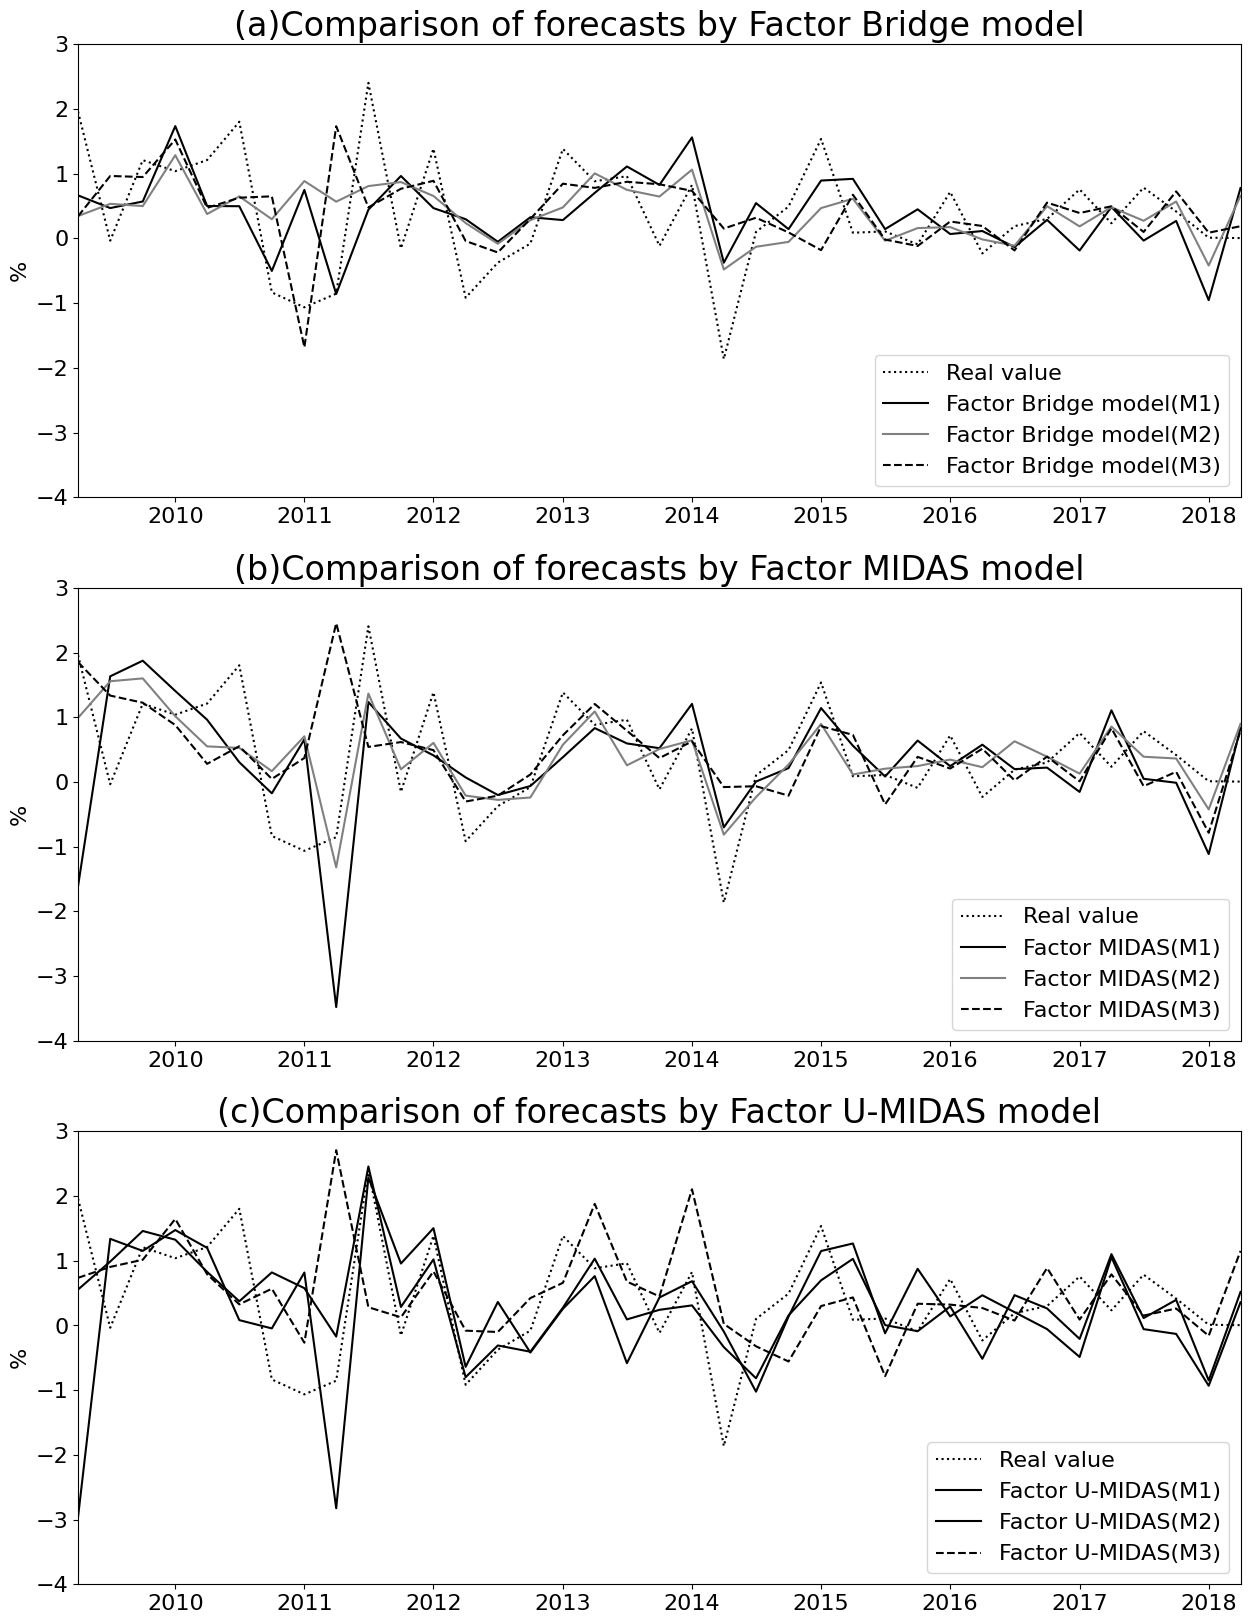

In [19]:
#####
# Draw the graph
fig = plt.figure(figsize=(15, 20))
ax1 = fig.add_subplot(3, 1, 1)
ax2 = fig.add_subplot(3, 1, 2)
ax3 = fig.add_subplot(3, 1, 3)
ax1.set_title("(a)Comparison of forecasts by Factor Bridge model", fontsize=24)
ax1.plot(qdti[PERIOD + 1 :], data_q[PERIOD+1:].to_numpy(), label="Real value", color="black", linestyle="dotted")
ax1.plot(qdti[PERIOD + 1 :], np.ravel(predict_result1_list), label="Factor Bridge model(M1)", color="black")
ax1.plot(qdti[PERIOD + 1 :], np.ravel(predict_result2_list), label="Factor Bridge model(M2)", color="grey")
ax1.plot(qdti[PERIOD + 1 :], np.ravel(predict_result3_list), label="Factor Bridge model(M3)", color="black", linestyle="dashed")
ax1.legend(loc="lower right", fontsize=16)
ax1.tick_params(labelsize=16)
ax1.set_xlim(qdti[PERIOD + 1], qdti[-1])
ax1.set_ylim(-4, 3)
ax1.set_ylabel("%", fontsize=16)
ax2.set_title("(b)Comparison of forecasts by Factor MIDAS model", fontsize=24)
ax2.plot(qdti[PERIOD + 1 :], data_q[PERIOD+1:].to_numpy(), label="Real value", color="black", linestyle="dotted")
ax2.plot(qdti[PERIOD + 1 :], np.ravel(predict_result4_list), label="Factor MIDAS(M1)", color="black")
ax2.plot(qdti[PERIOD + 1 :], np.ravel(predict_result5_list), label="Factor MIDAS(M2)", color="grey")
ax2.plot(qdti[PERIOD + 1 :], np.ravel(predict_result6_list), label="Factor MIDAS(M3)", color="black", linestyle="dashed")
ax2.legend(loc="lower right", fontsize=16)
ax2.tick_params(labelsize=16)
ax2.set_xlim(qdti[PERIOD + 1], qdti[-1])
ax2.set_ylim(-4, 3)
ax2.set_ylabel("%", fontsize=16)
ax3.set_title("(c)Comparison of forecasts by Factor U-MIDAS model", fontsize=24)
ax3.plot(qdti[PERIOD + 1 :], data_q[PERIOD+1:].to_numpy(), label="Real value", color="black", linestyle="dotted")
ax3.plot(qdti[PERIOD + 1 :], np.ravel(predict_result7_list), label="Factor U-MIDAS(M1)", color="black")
ax3.plot(qdti[PERIOD + 1 :], np.ravel(predict_result8_list), label="Factor U-MIDAS(M2)", color="black")
ax3.plot(qdti[PERIOD + 1 :], np.ravel(predict_result9_list), label="Factor U-MIDAS(M3)", color="black", linestyle="dashed")
ax3.legend(loc="lower right", fontsize=16)
ax3.tick_params(labelsize=16)
ax3.set_xlim(qdti[PERIOD + 1], qdti[-1])
ax3.set_ylim(-4, 3)
ax3.set_ylabel("%", fontsize=16)